In [1]:
# General purpose imports to handle paths, files etc
import os
import os.path as op
import glob
import pandas as pd
import numpy as np
import json


# Useful functions to define and import datasets from open neuro
import openneuro
from mne.datasets import sample
from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report


# Useful imports to define the direct download function below
import requests
import urllib.request
from tqdm import tqdm


# FSL function wrappers which we will call from python directly
from fsl.wrappers import fast, bet
from fsl.wrappers.misc import fslroi
from fsl.wrappers import flirt



def reset_overlays():
    """
    Clears view and completely remove visualization. All files opened in FSLeyes are closed.
    The view (along with any color map) is reset to the regular ortho panel.
    """
    l = frame.overlayList
    while(len(l)>0):
        del l[0]
    frame.removeViewPanel(frame.viewPanels[0])
    # Put back an ortho panel in our viz for future displays
    frame.addViewPanel(OrthoPanel)
    
def mkdir_no_exist(path):
    if not op.isdir(path):
        os.makedirs(path)
        
class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)


def download_url(url, output_path):
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, filename=output_path, reporthook=t.update_to)

def direct_file_download_open_neuro(file_list, file_types, dataset_id, dataset_version, save_dirs):
    # https://openneuro.org/crn/datasets/ds004226/snapshots/1.0.0/files/sub-001:sub-001_scans.tsv
    for i, n in enumerate(file_list):
        subject = n.split('_')[0]
        download_link = 'https://openneuro.org/crn/datasets/{}/snapshots/{}/files/{}:{}:{}'.format(dataset_id, dataset_version, subject, file_types[i],n)
        print('Attempting download from ', download_link)
        download_url(download_link, op.join(save_dirs[i], n))
        print('Ok')
        
def get_json_from_file(fname):
    f = open(fname)
    data = json.load(f)
    f.close()
    return data

In [2]:
#loading the data
dataset_id = 'ds000102'
subject = '01' 

# create dataset folder
sample_path = "dataset"
mkdir_no_exist(sample_path)
bids_root = op.join(os.path.abspath(""),sample_path, dataset_id)
deriv_root = op.join(bids_root, 'derivatives')
preproc_root = op.join(bids_root, 'derivatives','preprocessed_data')

mkdir_no_exist(bids_root)


func_path = op.join(bids_root, 'sub-01', 'func')
anat_path = op.join(bids_root, 'sub-01', 'anat')
mkdir_no_exist(op.join(bids_root, 'sub-01'))
mkdir_no_exist(func_path)
mkdir_no_exist(anat_path)

In [3]:
direct_file_download_open_neuro(file_list=['sub-01_task-flanker_run-1_bold.nii.gz', 
                                           'sub-01_task-flanker_run-2_bold.nii.gz',
                                           'sub-01_T1w.nii.gz'], 
                                file_types=['func', 'func', 'anat'], 
                                dataset_id=dataset_id, 
                                dataset_version='00001', 
                                save_dirs=[func_path,
                                           func_path,
                                           anat_path])

mkdir_no_exist(op.join(bids_root, 'derivatives'))
preproc_root = op.join(bids_root, 'derivatives','preprocessed_data')
mkdir_no_exist(preproc_root)
mkdir_no_exist(op.join(preproc_root, 'sub-01'))
mkdir_no_exist(op.join(preproc_root, 'sub-01', 'anat'))
mkdir_no_exist(op.join(preproc_root, 'sub-01', 'func'))
mkdir_no_exist(op.join(preproc_root, 'sub-01', 'fmap'))

Attempting download from  https://openneuro.org/crn/datasets/ds000102/snapshots/00001/files/sub-01:func:sub-01_task-flanker_run-1_bold.nii.gz


sub-01:func:sub-01_task-flanker_run-1_bold.nii.gz: 28.1MB [00:11, 2.38MB/s]                              


Ok
Attempting download from  https://openneuro.org/crn/datasets/ds000102/snapshots/00001/files/sub-01:func:sub-01_task-flanker_run-2_bold.nii.gz


sub-01:func:sub-01_task-flanker_run-2_bold.nii.gz: 28.1MB [00:08, 3.21MB/s]                            


Ok
Attempting download from  https://openneuro.org/crn/datasets/ds000102/snapshots/00001/files/sub-01:anat:sub-01_T1w.nii.gz


sub-01:anat:sub-01_T1w.nii.gz: 10.6MB [00:01, 5.47MB/s]                            

Ok


# 1- Visualizing data

Let's first begin to visualize the **anatomical scan** of our chosen subject: sub-01 !

In [10]:
reset_overlays()
load(op.join(bids_root, 'sub-01', 'anat', 'sub-01_T1w.nii.gz'))

Image(sub-01_T1w, /home/cfriedri/Desktop/MyFiles/NX-421/NSSP/dataset/ds000102/sub-01/anat/sub-01_T1w.nii.gz)

<img src="imgs/vis_anat.png">

And let's now visualize the **functional scan**.

In [11]:
reset_overlays()
load(op.join(bids_root, 'sub-01', 'func', 'sub-01_task-flanker_run-1_bold.nii.gz'))

Image(sub-01_task-flanker_run-1_bold, /home/cfriedri/Desktop/MyFiles/NX-421/NSSP/dataset/ds000102/sub-01/func/sub-01_task-flanker_run-1_bold.nii.gz)

<center><img src="imgs/vis_func_run1.gif"/>
    <p style="text-align:center;"><i>Functional data for sub01 for the first run of the Flanker task</i></p></center>


In [12]:
reset_overlays()
load(op.join(bids_root, 'sub-01', 'func', 'sub-01_task-flanker_run-2_bold.nii.gz'))

Image(sub-01_task-flanker_run-2_bold, /home/cfriedri/Desktop/MyFiles/NX-421/NSSP/dataset/ds000102/sub-01/func/sub-01_task-flanker_run-2_bold.nii.gz)

<center><img src="imgs/vis_func_run2.gif"/>
    <p style="text-align:center;"><i>Functional data for sub01 for the second run of the Flanker task</i></p></center>


# 2- Brain extraction
We will perform brain extraction on the anatomical volume, so basically remove the skull to end up only with the brain. To do this we will use the FSL program BET (*brain extraction tool*) which will generate a mask for the brain region of interest. 

The resulting mask will be stored in the *derivatives* folder to make sure that the raw source data is kept untouched.

In [39]:
# source anatomical data (raw)
anatomical_path = op.join(bids_root, 'sub-01', 'anat', 'sub-01_T1w.nii.gz')

In [31]:
# the extracted brain data
betted_brain_05_path = op.join(preproc_root, 'sub-01', 'anat', 'sub-01_T1w_05')

# the mask used for brain extraction
resulting_mask_05_path = op.join(preproc_root, 'sub-01', 'anat', 'sub-01_T1w_05_mask')

# the function to extract the brain knowing the mask parameters
bet(anatomical_path, betted_brain_05_path, mask=resulting_mask_05_path)

{}

In [34]:
reset_overlays()
load(anatomical_path)
load(resulting_mask_05_path)

Image(sub-01_T1w_05_mask, /home/cfriedri/Desktop/MyFiles/NX-421/NSSP/dataset/ds000102/derivatives/preprocessed_data/sub-01/anat/sub-01_T1w_05_mask.nii.gz)

<center><img src="imgs/bet_mask_default.png"/>
    <p style="text-align:center;"><i>Brain extraction on the anatomical image using a default fractional intensity threshold of 0.5</i></p></center>

The results above were obtained by using bet with a default fractional intensity threshold of 0.5. But let's explore the results with different franctional intensity thresholds ! For comparison we will focus on voxel (87,126,116)

> **_Fractional intensity threshold:_** ranging from 0 to 1, this threshold determines the amount of brain extracted by the mask. If we think that too much brain has been remove when using the default threshold, we should set this threshold to a smaller number to obtain a larger brain outline.


In [42]:
# to find threshold argument
help(bet)

Wrapper for the ``bet`` command.

    :arg mask:          Generate a brain mask
    :arg seg:           If ``False``, a brain extracted image is not
                        generated.
    :arg robust:        Robust brain centre estimation
    :arg fracintensity: Fractional intensity threshold

    Refer to the ``bet`` command-line help for details on all arguments.


In [40]:
# the extracted brain data
betted_brain_01_path = op.join(preproc_root, 'sub-01', 'anat', 'sub-01_T1w_01')

# the mask used for brain extraction
resulting_mask_01_path = op.join(preproc_root, 'sub-01', 'anat', 'sub-01_T1w_01_mask')

# the function to extract the brain knowing the mask parameters
bet(anatomical_path, betted_brain_01_path, mask=resulting_mask_01_path, fracintensity=0.1)

reset_overlays()
load(anatomical_path)
load(resulting_mask_01_path)

Image(sub-01_T1w_01_mask, /home/cfriedri/Desktop/MyFiles/NX-421/NSSP/dataset/ds000102/derivatives/preprocessed_data/sub-01/anat/sub-01_T1w_01_mask.nii.gz)

<center><img src="imgs/bet_mask_01.png"/>
    <p style="text-align:center;"><i>Brain extraction on the anatomical image using a fractional intensity threshold of 0.1</i></p></center>

We that by setting a lower fractional intensity threshold, a larger region of the brain is extracted by bet.

In [41]:
# the extracted brain data
betted_brain_09_path = op.join(preproc_root, 'sub-01', 'anat', 'sub-01_T1w_09')

# the mask used for brain extraction
resulting_mask_09_path = op.join(preproc_root, 'sub-01', 'anat', 'sub-01_T1w_09_mask')

# the function to extract the brain knowing the mask parameters
bet(anatomical_path, betted_brain_09_path, mask=resulting_mask_09_path, fracintensity=0.9)

reset_overlays()
load(anatomical_path)
load(resulting_mask_09_path)

Image(sub-01_T1w_09_mask, /home/cfriedri/Desktop/MyFiles/NX-421/NSSP/dataset/ds000102/derivatives/preprocessed_data/sub-01/anat/sub-01_T1w_09_mask.nii.gz)

<center><img src="imgs/bet_mask_09.png"/>
    <p style="text-align:center;"><i>Brain extraction on the anatomical image using a fractional intensity threshold of 0.9</i></p></center>

We that by setting a higher fractional intensity threshold, a more restricted region of the brain is extracted by bet.

# 3- Motion correction

### a) Motion parameters

In [4]:
path_original_data = os.path.join(bids_root, 'sub-01', 'func', 'sub-01_task-flanker_run-1_bold.nii.gz')
path_moco_data = os.path.join(preproc_root, 'sub-01', 'func', 'sub-01_task-flanker_run-1_bold_moco')
mcflirt(infile=path_original_data,o=path_moco_data, plots=True, report=True, dof=6, mats=True)

Processed data will be saved as /home/ffriedli/Desktop/MyFiles/NSSP/dataset/ds000102/derivatives/preprocessed_data/sub-01/func/sub-01_task-flanker_run-1_bold_moco

McFLIRT v 2.0 - FMRI motion correction

Reading time series... 
first iteration - 8mm scaling, set tolerance
Rescaling reference volume [73] to 8 mm pixels
Registering volumes ... [74][75][76][77][78][79][80][81][82][83][84][85][86][87][88][89][90][91][92][93][94][95][96][97][98][99][100][101][102][103][104][105][106][107][108][109][110][111][112][113][114][115][116][117][118][119][120][121][122][123][124][125][126][127][128][129][130][131][132][133][134][135][136][137][138][139][140][141][142][143][144][145][72][71][70][69][68][67][66][65][64][63][62][61][60][59][58][57][56][55][54][53][52][51][50][49][48][47][46][45][44][43][42][41][40][39][38][37][36][35][34][33][32][31][30][29][28][27][26][25][24][23][22][21][20][19][18][17][16][15][14][13][12][11][10][9][8][7][6][5][4][3][2][1][0]
second iteration - drop to 4mm scaling


refnum = 73
Original_refvol = -1


Registering volumes ... [74][75][76][77][78][79][80][81][82][83][84][85][86][87][88][89][90][91][92][93][94][95][96][97][98][99][100][101][102][103][104][105][106][107][108][109][110][111][112][113][114][115][116][117][118][119][120][121][122][123][124][125][126][127][128][129][130][131][132][133][134][135][136][137][138][139][140][141][142][143][144][145][72][71][70][69][68][67][66][65][64][63][62][61][60][59][58][57][56][55][54][53][52][51][50][49][48][47][46][45][44][43][42][41][40][39][38][37][36][35][34][33][32][31][30][29][28][27][26][25][24][23][22][21][20][19][18][17][16][15][14][13][12][11][10][9][8][7][6][5][4][3][2][1][0]
Saving motion corrected time series... 


{}

In [5]:
reset_overlays()
load(path_original_data)
load(path_moco_data)

Image(sub-01_task-flanker_run-1_bold_moco, /home/ffriedli/Desktop/MyFiles/NSSP/dataset/ds000102/derivatives/preprocessed_data/sub-01/func/sub-01_task-flanker_run-1_bold_moco.nii.gz)

In [6]:
def load_mot_params_fsl_6_dof(path):
    return pd.read_csv(path, sep='  ', header=None, 
            engine='python', names=['Rotation x', 'Rotation y', 'Rotation z','Translation x', 'Translation y', 'Translation z'])

mot_params = load_mot_params_fsl_6_dof(op.join(preproc_root, 'sub-01', 'func', 'sub-01_task-flanker_run-1_bold_moco.par'))
mot_params

,Rotation x,Rotation y,Rotation z,Translation x,Translation y,Translation z
0,-0.002731,-0.002763,-0.002376,-0.154286,0.011919,0.032888
1,-0.002989,-0.002625,-0.002376,-0.158850,0.027467,0.087529
2,-0.002903,-0.002552,-0.002242,-0.166514,0.026961,0.099782
3,-0.002523,-0.002763,-0.002376,-0.166644,0.014205,0.087150
4,-0.002404,-0.002709,-0.002376,-0.168801,-0.007525,0.062447
...,...,...,...,...,...,...
141,0.001576,0.000096,-0.001420,-0.047908,0.071218,-0.203898
142,0.001383,-0.000248,-0.001420,-0.041588,0.098485,-0.208978
143,0.001342,-0.000108,-0.001420,-0.036894,0.079022,-0.195061
144,0.001722,-0.000180,-0.001420,-0.036915,0.094487,-0.209467


In [7]:
def compute_FD_power(mot_params):
    framewise_diff = mot_params.diff().iloc[1:]

    rot_params = framewise_diff[['Rotation x', 'Rotation y', 'Rotation z']]
    # Estimating displacement on a 50mm radius sphere
    # To know this one, we can remember the definition of the radian!
    # Indeed, let the radian be theta, the arc length be s and the radius be r.
    # Then theta = s / r
    # We want to determine here s, for a sphere of 50mm radius and knowing theta. Easy enough!
    
    # Another way to think about it is through the line integral along the circle.
    # Integrating from 0 to theta with radius 50 will give you, unsurprisingly, r0 theta.
    converted_rots = rot_params*50
    trans_params = framewise_diff[['Translation x', 'Translation y', 'Translation z']]
    fd = converted_rots.abs().sum(axis=1) + trans_params.abs().sum(axis=1)
    return fd

fd = compute_FD_power(mot_params).to_numpy()

In [8]:
threshold = np.quantile(fd,0.75) + 1.5*(np.quantile(fd,0.75) - np.quantile(fd,0.25))

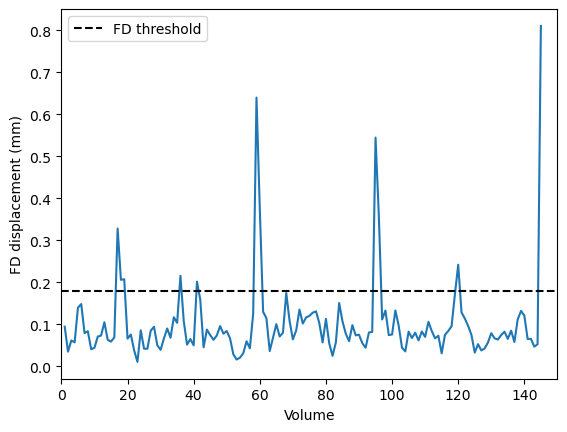

In [17]:
%matplotlib inline
plt.plot(list(range(1, fd.size+1)), fd)
plt.xlabel('Volume')
plt.xlim([0,150])
plt.ylabel('FD displacement (mm)')
plt.hlines(threshold, 0, 370,colors='black', linestyles='dashed', label='FD threshold')
plt.legend()
plt.show()

In [10]:
np.where(fd > threshold)[0] + 1

array([ 17,  18,  19,  36,  41,  59,  60,  95,  96, 120, 145])

In [18]:
path_original_data = os.path.join(bids_root, 'sub-01', 'func', 'sub-01_task-flanker_run-2_bold.nii.gz')
path_moco_data = os.path.join(preproc_root, 'sub-01', 'func', 'sub-01_task-flanker_run-2_bold_moco')
mcflirt(infile=path_original_data,o=path_moco_data, plots=True, report=True, dof=6, mats=True)

Processed data will be saved as /home/ffriedli/Desktop/MyFiles/NSSP/dataset/ds000102/derivatives/preprocessed_data/sub-01/func/sub-01_task-flanker_run-2_bold_moco

McFLIRT v 2.0 - FMRI motion correction

Reading time series... 
first iteration - 8mm scaling, set tolerance
Rescaling reference volume [73] to 8 mm pixels
Registering volumes ... [74][75][76][77][78][79][80][81][82][83][84][85][86][87][88][89][90][91][92][93][94][95][96][97][98][99][100][101][102][103][104][105][106][107][108][109][110][111][112][113][114][115][116][117][118][119][120][121][122][123][124][125][126][127][128][129][130][131][132][133][134][135][136][137][138][139][140][141][142][143][144][145][72][71][70][69][68][67][66][65][64][63][62][61][60][59][58][57][56][55][54][53][52][51][50][49][48][47][46][45][44][43][42][41][40][39][38][37][36][35][34][33][32][31][30][29][28][27][26][25][24][23][22][21][20][19][18][17][16][15][14][13][12][11][10][9][8][7][6][5][4][3][2][1][0]
second iteration - drop to 4mm scaling


refnum = 73
Original_refvol = -1


Registering volumes ... [74][75][76][77][78][79][80][81][82][83][84][85][86][87][88][89][90][91][92][93][94][95][96][97][98][99][100][101][102][103][104][105][106][107][108][109][110][111][112][113][114][115][116][117][118][119][120][121][122][123][124][125][126][127][128][129][130][131][132][133][134][135][136][137][138][139][140][141][142][143][144][145][72][71][70][69][68][67][66][65][64][63][62][61][60][59][58][57][56][55][54][53][52][51][50][49][48][47][46][45][44][43][42][41][40][39][38][37][36][35][34][33][32][31][30][29][28][27][26][25][24][23][22][21][20][19][18][17][16][15][14][13][12][11][10][9][8][7][6][5][4][3][2][1][0]
Saving motion corrected time series... 


{}

In [31]:
reset_overlays()
load(path_original_data)
load(path_moco_data)

Image(sub-01_task-flanker_run-2_bold_moco, /home/ffriedli/Desktop/MyFiles/NSSP/dataset/ds000102/derivatives/preprocessed_data/sub-01/func/sub-01_task-flanker_run-2_bold_moco.nii.gz)

3) For motion corrected data select a Volume and visualize it 

In [27]:
output_path_volume = os.path.join(preproc_root, 'sub-01', 'func', 'sub-01_task-flanker_run-1_bold_bbr')
fslroi(path_moco_data,output_path_volume, str(50), str(1))

{}

In [28]:
reset_overlays()
load(output_path_volume)

Image(sub-01_task-flanker_run-1_bold_bbr, /home/ffriedli/Desktop/MyFiles/NSSP/dataset/ds000102/derivatives/preprocessed_data/sub-01/func/sub-01_task-flanker_run-1_bold_bbr.nii.gz)

<center><img src="imgs/Volume_of_choice.png"/>
    <p style="text-align:center;"><i>Volume Extraction</i></p></center>